Name - sharik Gazi
roll- IDS2022009

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt

In [ ]:

# Set the path to your dataset folder
dataset_path = "/content/drive/MyDrive/data"

# Set the image size (adjust as needed)
image_size = (224, 224)

# Set the batch size and number of epochs
batch_size = 16
#epochs = 100

# Function to load and preprocess the images
def load_images(folder_path):
    images = []
    labels = []
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, filename)
            image = Image.open(image_path).convert("RGB")

            image = image.resize(image_size)
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(subfolder)
    return np.array(images), np.array(labels)


In [ ]:

# Load the images and labels
images, labels = load_images(dataset_path)

# Convert labels to binary values (0 or 1)
labels = np.where(labels == 'yes', 1, 0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create an ImageDataGenerator instance with data augmentation options
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [ ]:
# Load the pre-trained VGG16 model without the top layers
# 50 epochs
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())  # Add Batch Normalization

model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dense(1, activation="sigmoid"))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_103 (Ba  (None, 25088)            100352    
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 4096)              102764544 
                                                                 
 dropout_6 (Dropout)         (None, 4096)              0         
                                                                 
 batch_normalization_104 (Ba  (None, 4096)             16384     
 tchNormalization)                                    

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(X_train) // batch_size,
          epochs=1,
          validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()

# Convert predictions and ground truth labels to integers
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=["No Tumor", "Tumor"])
print("Classification Report:")
print(report)

2/2 [==============================] - 0s 133ms/step - loss: 0.2579 - accuracy: 0.8627
Test loss: 0.2579
Test accuracy: 0.8627
2/2 [==============================] - 0s 124ms/step
Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.81      0.85      0.83        20
       Tumor       0.90      0.87      0.89        31

    accuracy                           0.86        51
   macro avg       0.85      0.86      0.86        51
weighted avg       0.86      0.86      0.86        51



In [ ]:
confusion_matrix(y_test, y_pred)

array([[17,  3],
       [ 4, 27]])

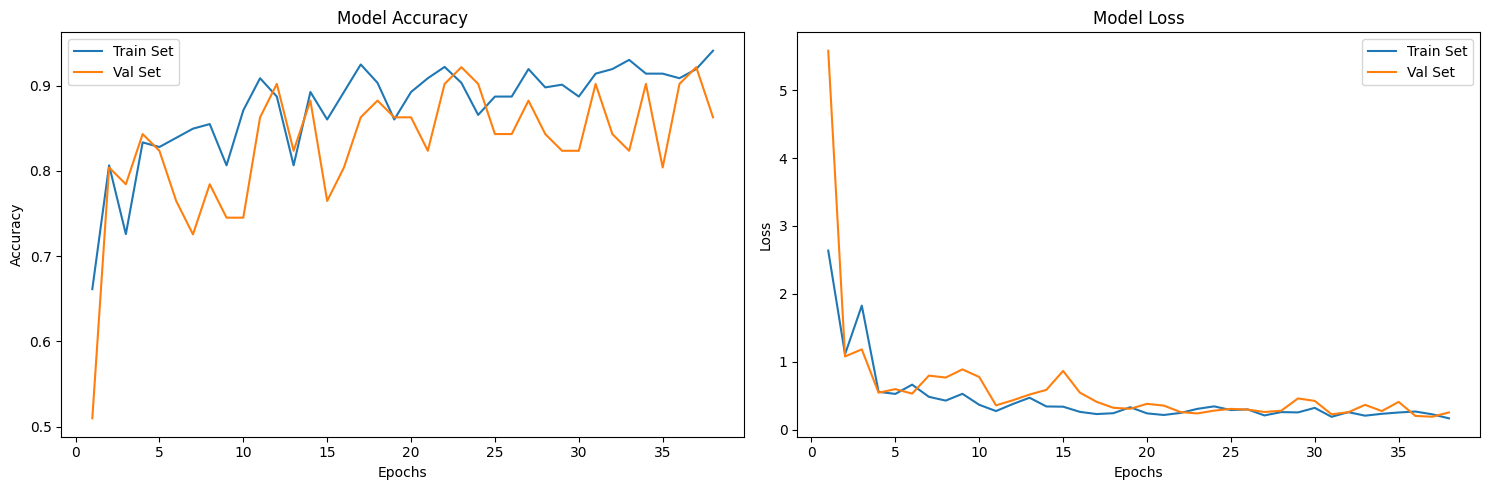

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.save("Brain_VGG16_model.h5")

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('Brain_VGG16_model.pkl', 'wb'))

In [ ]:
from google.colab import files
files.download('Brain_Vgg16.h5')

FileNotFoundError: ignored

In [ ]:
from google.colab import files
files.download('Brain_VGG16_model.pkl')